# Moran's tests
Master thesis of Nikolai Popov, MAE-2025

In [1]:
# Libraries import
import pandas as pd # dataframes
import numpy as np # for matrices/vectors
import warnings # to supress warninings
warnings.simplefilter(action='ignore', category=Warning)
from scipy.spatial import distance_matrix # for distance matrix creation
import geopandas as gpd # to to read shape files
from scipy.sparse import load_npz, diags # to download the W_N and make diagp - to build diagonal matrices
from libpysal.weights import WSP # to work with sparse inputs
from esda.moran import Moran # for Moran's test
import matplotlib.pyplot as plt # for plots
import statsmodels.formula.api as smf #estimate regression models using R-style formulas
import re # for regular expressions

Load the data.

In [2]:
balanced_df = pd.read_csv("C:/Users/Popov/Documents/Research/Volchkova_thesis/Data/Cleaned_datasets/balanced_dataset_file_collab.csv", 
                          sep=",", on_bad_lines="skip", low_memory=False)

W_N_sparse = load_npz("C:/Users/Popov/Documents/Research/Volchkova_thesis/Data/Cleaned_datasets/W_N_sparse.npz")

Moran’s tests by Year for "Capital" and "Output"

At first, make W_N row-normalized (specifically for Moran's tests)

In [3]:
# Row-standardize the matrix
row_sums = np.array(W_N_sparse.sum(axis=1)).flatten()
row_inv = 1.0 / row_sums
D_inv = diags(row_inv)
W_row_std = D_inv.dot(W_N_sparse)

# Convert to PySAL weights object 
w_pysal = WSP(W_row_std)

Now to the tests themselves.

In [4]:
# Moran's test for Capital, Output, and Labor for each year
w_standard = w_pysal.to_W()
results = []

for var in ["Capital", "Output", "Labor"]:  # Added "Labor"
    print(f"\n--- Moran's I for {var} ---")
    
    for year in sorted(balanced_df['Year'].unique()):
        y_t = balanced_df[balanced_df['Year'] == year][var].values

        if np.isnan(y_t).any():
            print(f"Skipping year {year} due to missing values.")
            continue

        # Use transformation="O" for already-standardized W
        moran = Moran(y_t, w_standard, transformation="O")

        print(f"Year {year} | Moran's I: {moran.I:.4f} | p-value: {moran.p_sim:.4f}")

        results.append({
            'variable': var,
            'year': year,
            'moran_i': moran.I,
            'p_value': moran.p_sim
        })

results_df = pd.DataFrame(results)


--- Moran's I for Capital ---
Year 2011 | Moran's I: 0.0074 | p-value: 0.0030
Year 2012 | Moran's I: 0.0106 | p-value: 0.0010
Year 2013 | Moran's I: 0.0130 | p-value: 0.0020
Year 2014 | Moran's I: 0.0127 | p-value: 0.0010
Year 2015 | Moran's I: 0.0112 | p-value: 0.0010
Year 2016 | Moran's I: 0.0106 | p-value: 0.0010

--- Moran's I for Output ---
Year 2011 | Moran's I: 0.0033 | p-value: 0.0130
Year 2012 | Moran's I: 0.0069 | p-value: 0.0030
Year 2013 | Moran's I: 0.0120 | p-value: 0.0020
Year 2014 | Moran's I: 0.0141 | p-value: 0.0010
Year 2015 | Moran's I: 0.0140 | p-value: 0.0010
Year 2016 | Moran's I: 0.0142 | p-value: 0.0020

--- Moran's I for Labor ---
Year 2011 | Moran's I: 0.0115 | p-value: 0.0010
Year 2012 | Moran's I: 0.0158 | p-value: 0.0010
Year 2013 | Moran's I: 0.0182 | p-value: 0.0010
Year 2014 | Moran's I: 0.0188 | p-value: 0.0020
Year 2015 | Moran's I: 0.0186 | p-value: 0.0010
Year 2016 | Moran's I: 0.0138 | p-value: 0.0010


In [5]:
results_df

,variable,year,moran_i,p_value
0,Capital,2011,0.007440,0.003
1,Capital,2012,0.010569,0.001
2,Capital,2013,0.012962,0.002
3,Capital,2014,0.012660,0.001
4,Capital,2015,0.011198,0.001
5,Capital,2016,0.010555,0.001
6,Output,2011,0.003334,0.013
7,Output,2012,0.006871,0.003
8,Output,2013,0.012009,0.002
9,Output,2014,0.014079,0.001


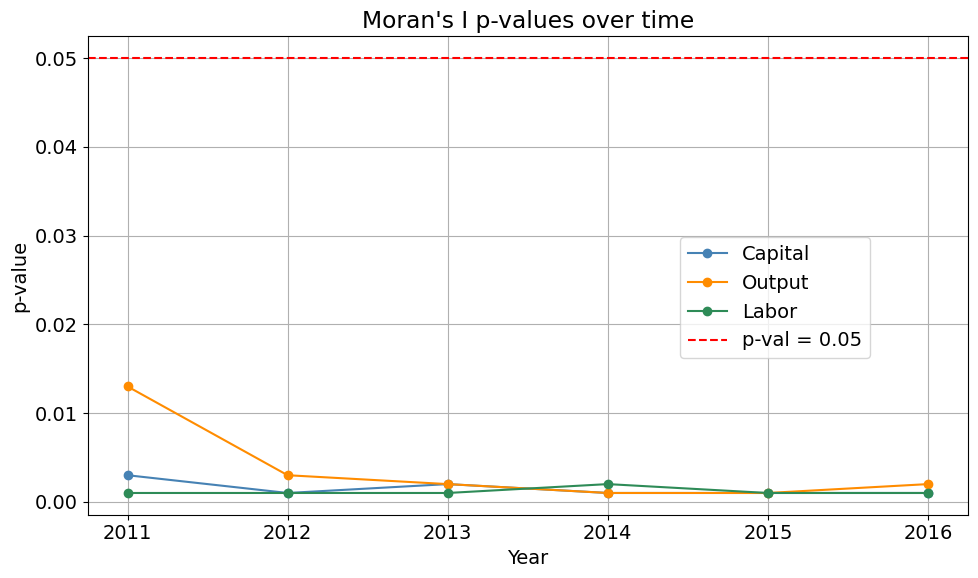

In [6]:
plt.figure(figsize=(10, 6))

# Increase overall font size
plt.rcParams.update({'font.size': 14})

# Custom colors
colors = {
    "Capital": "steelblue",
    "Output": "darkorange",
    "Labor": "seagreen"  # Add Labor with a distinct color
}

# Plot p-values by variable
for var in results_df["variable"].unique():
    subset = results_df[results_df["variable"] == var]
    plt.plot(subset["year"], subset["p_value"], marker='o', label=var, color=colors.get(var, 'gray'))

# Reference line at p = 0.05
plt.axhline(y=0.05, color='red', linestyle='--', label='p-val = 0.05')

# Formatting
plt.xlabel("Year")
plt.ylabel("p-value")
plt.title("Moran's I p-values over time")
plt.legend(loc='upper right', bbox_to_anchor=(0.9, 0.6))
plt.grid(True)
plt.tight_layout()

# Save the plot
output_dir = "C:/Users/Popov/Documents/Research/Volchkova_thesis/Output"
image_path = f"{output_dir}/Moran_test_plot.png"
plt.savefig(image_path, dpi=1000, bbox_inches='tight')
plt.show()